# No Encoding - Model testing

In [273]:
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model

## Data Loading

In [28]:
## defining a frame for image and mask storage
Train = {'img' : [], 'mask' : []}
Validation = {'img' : [], 'mask' : []}
Test = {'img' : [], 'mask' : []}


## defining data Loader function
def LoadData(Obj = None, imgPath = None, maskPath = None, shape = 256):
    imgNames = os.listdir(imgPath)
    maskNames = []
    
    ## generating mask names labeling them if the name is the same as the images
    for mem in imgNames:
        maskNames.append(re.sub('\.png', '_L.png', mem))
    
    img_path = imgPath + '/'
    mask_path = maskPath + '/'
    
    for i in range (len(imgNames)):
        img = plt.imread(img_path + imgNames[i])
        mask = plt.imread(mask_path + maskNames[i])
        
        img = cv2.resize(img, (shape, shape)) 
        mask = cv2.resize(mask, (shape, shape))
        
        Obj['img'].append(img)
        Obj['mask'].append(mask)
        
    return Obj

In [29]:
Train = LoadData(Train, imgPath = '/kaggle/input/camvid/CamVid/train', maskPath = '/kaggle/input/camvid/CamVid/train_labels', shape = 256)
Validation = LoadData(Validation, imgPath = '/kaggle/input/camvid/CamVid/val', maskPath = '/kaggle/input/camvid/CamVid/val_labels', shape = 256)
Test = LoadData(Test, imgPath = '/kaggle/input/camvid/CamVid/test', maskPath = '/kaggle/input/camvid/CamVid/test_labels', shape = 256)

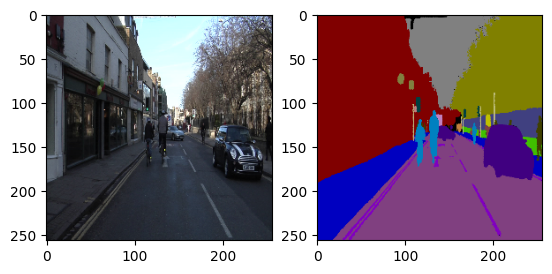

In [30]:
plt.subplot(1,2,1)
plt.imshow(Train['img'][1])
plt.subplot(1,2,2)
plt.imshow(Train['mask'][1])
plt.show()

## Functions - Models, inference and delivery

In [31]:
# General
import tensorflow as tf
from tensorflow.keras import backend as K

# Network Architecture
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, Dropout, BatchNormalization, Activation, Add
from keras.optimizers import Adam

# Metrics
from keras.metrics import MeanIoU


############################################################################################################################################################################

# BLOCKS
def contraction_block(input_tensor, num_filters, doBatchNorm = True, drop_rate = None):
    x = Conv2D(num_filters, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(input_tensor)      # strides default to 1
    if doBatchNorm:
        x = BatchNormalization()(x)             # to make computations more efficient
    x = Activation('relu')(x)
    
    x = Conv2D(num_filters, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(x)
    if doBatchNorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    pooled = MaxPooling2D((2, 2))(x)            # OG paper proposed strides=2 but we leave them default to pool_size = 2
    pooled = Dropout(drop_rate)(pooled)
    return x, pooled



def expansive_block(copy, input_tensor, num_filters, doBatchNorm = True, drop_rate = None):  
    # Conv2dtranspose =! upsampling (both the concept and the keras layer). both increase dim of arrays.
    # upsampling2d is the opposite of pooling repeating rows and columns of input.
    # Conv2dtranspose performs upsampling and then convolution. 
    x = Conv2DTranspose(num_filters, kernel_size = (3, 3), strides = (2, 2), padding='same')(input_tensor)       

    # Concatenation: crop the copy from the specular contraction block and concatenate it to the
    # current respective decoder layer of the expansive path
    x = concatenate([x, copy])

    # add simple 2D convolutions
    x = Conv2D(num_filters, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(x)      # strides default to 1
    if doBatchNorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(num_filters, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(x)
    if doBatchNorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(drop_rate)(x)
    return x


# will be useful also for autoencoder
def convolution_block(input_tensor, num_filters, drop_rate = None, doBatchNorm = True):
    x = Conv2D(num_filters, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(input_tensor)
    if doBatchNorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(x)
    if doBatchNorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(drop_rate)(x)
    return x


# UNET
def Unet(input_size, filters = 16, n_classes = None, activation='sigmoid'):
    input_layer = Input(input_size)

    copy1, p1 = contraction_block(input_tensor=input_layer, num_filters = filters*1, drop_rate=0.1, doBatchNorm=True)
    copy2, p2 = contraction_block(input_tensor=p1, num_filters = filters*2, drop_rate=0.1, doBatchNorm=True)
    copy3, p3 = contraction_block(input_tensor=p2, num_filters = filters*4, drop_rate=0.2, doBatchNorm=True)
    copy4, p4 = contraction_block(input_tensor=p3, num_filters = filters*8, drop_rate=0.2, doBatchNorm=True)

    x5 = convolution_block(input_tensor=p4, num_filters=filters*16, drop_rate = 0.2, doBatchNorm=True)

    p6 = expansive_block(copy=copy4, input_tensor=x5, num_filters = filters*8, drop_rate = 0.2, doBatchNorm=True)
    p7 = expansive_block(copy=copy3, input_tensor=p6, num_filters = filters*4, drop_rate = 0.2, doBatchNorm=True)
    p8 = expansive_block(copy=copy2, input_tensor=p7, num_filters = filters*2, drop_rate = 0.1, doBatchNorm=True)
    p9 = expansive_block(copy=copy1, input_tensor=p8, num_filters = filters*1, drop_rate = 0.1, doBatchNorm=True)

    # num_classes should be 3 if working with OG images and masks
    output = Conv2D(filters=n_classes, kernel_size=(1, 1), activation=activation)(p9)
    model = Model(inputs=[input_layer], outputs=[output], name='Unet')
    return model

################################################################################################################################

# Autoencoder
# upsample_block for autoencoder
def upsample_block(input_tensor, num_filters, doBatchNorm = True):
    x = Conv2DTranspose(num_filters, kernel_size=(3, 3), strides = (2, 2), padding='same')(input_tensor)
    x = Conv2D(num_filters, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(x)
    if doBatchNorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(x)
    if doBatchNorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def encoder(inputs, filters = 16):
    # will not use the copies since there are no skip connections
    _, p1 = contraction_block(input_tensor = inputs, num_filters = filters*1, drop_rate=0, doBatchNorm=True)
    _, p2 = contraction_block(input_tensor = p1, num_filters = filters*2, drop_rate=0, doBatchNorm=True)
    _, p3 = contraction_block(input_tensor = p2, num_filters = filters*4, drop_rate=0, doBatchNorm=True)
    _, p4 = contraction_block(input_tensor = p3, num_filters = filters*8, drop_rate=0, doBatchNorm=True)

    p5 = convolution_block(input_tensor = p4, num_filters = filters*16, drop_rate = 0, doBatchNorm=True)
    return p5

def decoder(inputs, filters = 16):
    u1 = upsample_block(input_tensor = inputs, num_filters = filters*8, doBatchNorm=True)
    u2 = upsample_block(input_tensor = u1, num_filters = filters*4, doBatchNorm=True)
    u3 = upsample_block(input_tensor = u2, num_filters = filters*2, doBatchNorm=True)
    u4 = upsample_block(input_tensor = u3, num_filters = filters*1, doBatchNorm=True)
    decoded = Conv2D(3, 3, padding="same", activation="sigmoid")(u4)        # sigmoid since reconstruction
    return decoded

def autoencoder(input_size):
    input_layer = Input(input_size)
    autoencoder = Model(input_layer, decoder(encoder(input_layer)))
    return autoencoder


# Residual block: https://arxiv.org/ftp/arxiv/papers/1802/1802.06955.pdf (fig 4)
# there are 2 variants (2. is the one proposed in OG paper of ResNet)
# 1. conv - BN - Activation - conv - BN - Activation - shortcut  - BN - shortcut+BN
# 2. conv - BN - Activation - conv - BN - shortcut  - BN - addition() - Activation
def residual_contraction_block(input_tensor, num_filters, doBatchNorm = True): 
    x = Conv2D(num_filters, kernel_size=(3, 3), padding='same')(input_tensor)       # default kernel initializer to "glorot_uniform"
    if doBatchNorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(num_filters, kernel_size=(3, 3), padding='same')(x)
    if doBatchNorm:
        x = BatchNormalization()(x)
    # x = Activation('relu')(x)    #Activation before addition with residual

    # 1x1 convolution on input image
    residual = Conv2D(num_filters, kernel_size=(1, 1), padding='same')(input_tensor)
    if doBatchNorm:
        residual = BatchNormalization()(residual)
    
    # sum convolution block with residual and perform 2x2 max pooling
    res_x = Add()([residual, x])
    res_x = Activation('relu')(res_x)       # act f in the end like the OG paper proposes
    # pooled = MaxPooling2D((2, 2))(res_x)
    # pooled = Dropout(drop_rate)(pooled)
    # return pooled
    return res_x


def ResUnet(input_size, filters = 16, n_classes = None, activation='sigmoid'):
    input_layer = Input(input_size)

    # downsample
    x1 = residual_contraction_block(input_tensor=input_layer, num_filters = filters*1, doBatchNorm = True)    
    p1 = MaxPooling2D((2, 2))(x1)
    p1 = Dropout(rate=0.1)(p1)

    x2 = residual_contraction_block(input_tensor=p1, num_filters = filters*2, doBatchNorm = True)    
    p2 = MaxPooling2D((2, 2))(x2)
    p2 = Dropout(rate=0.1)(p2)

    x3 = residual_contraction_block(input_tensor=p2, num_filters = filters*4, doBatchNorm = True)    
    p3 = MaxPooling2D((2, 2))(x3)
    p3 = Dropout(rate=0.2)(p3)

    x4 = residual_contraction_block(input_tensor=p3, num_filters = filters*8, doBatchNorm = True)    
    p4 = MaxPooling2D((2, 2))(x4)
    p4 = Dropout(rate=0.2)(p4)

    # intermediate
    x5 = residual_contraction_block(input_tensor=p4, num_filters = filters*16, doBatchNorm = True)
    x5 = Dropout(rate=0.2)(x5)

    # upsample
    x6 = Conv2DTranspose(filters = filters*8, kernel_size = (3, 3), strides = (2, 2), padding='same')(x5)
    x7 = concatenate([x6, x4])
    x8 = residual_contraction_block(input_tensor=x7, num_filters = filters*8, doBatchNorm = True)
    x8 = Dropout(rate=0.2)(x8)

    x9 = Conv2DTranspose(filters = filters*4, kernel_size = (3, 3), strides = (2, 2), padding='same')(x8)
    x10 = concatenate([x9, x3])
    x11 = residual_contraction_block(input_tensor=x10, num_filters = filters*4, doBatchNorm = True)
    x11 = Dropout(rate=0.2)(x11)

    x12 = Conv2DTranspose(filters = filters*2, kernel_size = (3, 3), strides = (2, 2), padding='same')(x11)
    x13 = concatenate([x12, x2])
    x14 = residual_contraction_block(input_tensor=x13, num_filters = filters*2, doBatchNorm = True)
    x14 = Dropout(rate=0.1)(x14)

    x15 = Conv2DTranspose(filters = filters*1, kernel_size = (3, 3), strides = (2, 2), padding='same')(x14)
    x16 = concatenate([x15, x1])
    x17 = residual_contraction_block(input_tensor=x16, num_filters = filters*1, doBatchNorm = True)
    x17 = Dropout(rate=0.1)(x17)

    output = Conv2D(filters=n_classes, kernel_size=(1, 1), activation=activation)(x17)
    model = Model(inputs=[input_layer], outputs=[output], name='ResUnet')
    return model    


In [ ]:
# function for getting 16 predictions
def predict_batch(valMap, model, shape = 256):
    #model.load_weights('/kaggle/input/weights-and-vedio/model_weights_150_runs.h5')

    img = valMap['img']
    mask = valMap['mask']
    mask = mask[0:16]
    
    imgProc = img[0:16]
    imgProc = np.array(img)
    
    predictions = model.predict(imgProc)
#     for i in range(len(predictions)):
#         predictions[i] = cv2.merge((predictions[i,:,:,0],predictions[i,:,:,1],predictions[i,:,:,2]))
    
    return predictions, imgProc, mask
    

    
    
def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(7,7))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('image')
    
    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted Mask')
    
    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('actual Mask')

## Unet - Training and inference

We will train the models for many epochs since this is a complicated task: overfitting is not a problem therefore we push the model training with more epochs to learn more and more even is if there no big improvement on the loss function.

In [32]:
IMG_HEIGHT = 256
IMG_WIDTH  = 256
IMG_CHANNELS = 3

shapes = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
unet = Unet(input_size=shapes, filters = 16, n_classes = 3, activation='sigmoid')
unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.summary()

#### Each of the classes need to have a sigmoid output which makes each prediction independent of other classes. there you can use binary cross entropy to calculate the overall error/loss. Meaning we are doing a One-vs-All prediction using a loss function designed for binary classification tasks.

In [33]:
history_unet = unet.fit(np.array(Train['img']),np.array(Train['mask']),
                        epochs = 150, verbose = 1,
                        batch_size = 8,
                        validation_data = (np.array(Test['img']),np.array(Test['mask'])))   # usin test since it is bigger than validation

Epoch 1/150


2024-02-02 11:15:36.316504: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inUnet/dropout_9/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


47/47 [==============================] - 19s 128ms/step - loss: 0.6578 - accuracy: 0.3849 - val_loss: 2.5141 - val_accuracy: 0.3042
Epoch 2/150
47/47 [==============================] - 4s 95ms/step - loss: 0.5975 - accuracy: 0.5121 - val_loss: 0.7376 - val_accuracy: 0.2569
Epoch 3/150
47/47 [==============================] - 4s 96ms/step - loss: 0.5767 - accuracy: 0.5467 - val_loss: 0.6955 - val_accuracy: 0.6028
Epoch 4/150
47/47 [==============================] - 4s 96ms/step - loss: 0.5642 - accuracy: 0.5853 - val_loss: 0.6905 - val_accuracy: 0.3960
Epoch 5/150
47/47 [==============================] - 4s 96ms/step - loss: 0.5556 - accuracy: 0.5973 - val_loss: 0.7618 - val_accuracy: 0.4244
Epoch 6/150
47/47 [==============================] - 4s 96ms/step - loss: 0.5484 - accuracy: 0.5972 - val_loss: 0.9345 - val_accuracy: 0.2787
Epoch 7/150
47/47 [==============================] - 5s 97ms/step - loss: 0.5459 - accuracy: 0.5875 - val_loss: 0.6804 - val_accuracy: 0.6184
Epoch 8/150
47/4

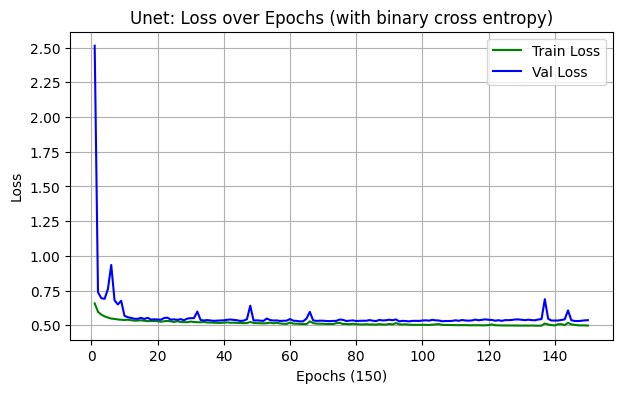

In [48]:
train_loss_history_unet = history_unet.history['loss']
val_loss_history_unet = history_unet.history['val_loss']


epochs = np.arange(1, len(val_loss_history_unet)+1)

plt.figure(figsize=(7, 4))


plt.plot(epochs, train_loss_history_unet, label='Train Loss', color='green')
plt.plot(epochs, val_loss_history_unet, label='Val Loss', color='blue')


plt.title('Unet: Loss over Epochs (with binary cross entropy)')
plt.xlabel('Epochs (150)')
plt.ylabel('Loss')
plt.legend()

plt.grid(True)
plt.show()

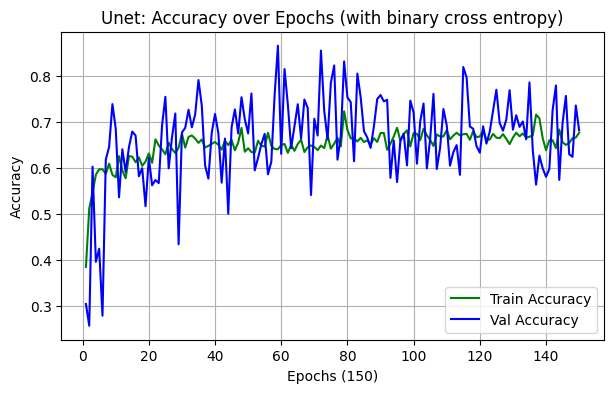

In [36]:
train_acc_history_unet = history_unet.history['accuracy']
val_acc_history_unet = history_unet.history['val_accuracy']


epochs = np.arange(1, len(val_acc_history_unet)+1)

plt.figure(figsize=(7, 4))


plt.plot(epochs, train_acc_history_unet, label='Train Accuracy', color='green')
plt.plot(epochs, val_acc_history_unet, label='Val Accuracy', color='blue')


plt.title('Unet: Accuracy over Epochs (with binary cross entropy)')
plt.xlabel('Epochs (150)')
plt.ylabel('Accuracy')
plt.legend()

plt.grid(True)
plt.show()

In [255]:
unet.evaluate(np.array(Validation['img']), np.array(Validation['mask']))

4/4 [==============================] - 0s 51ms/step - loss: 0.5228 - accuracy: 0.6281


[0.5228488445281982, 0.6280566453933716]

In [34]:
sixteenPrediction, actuals, masks = predict_batch(Validation, unet)

4/4 [==============================] - 1s 58ms/step


In [265]:
len(Validation['img'])

100

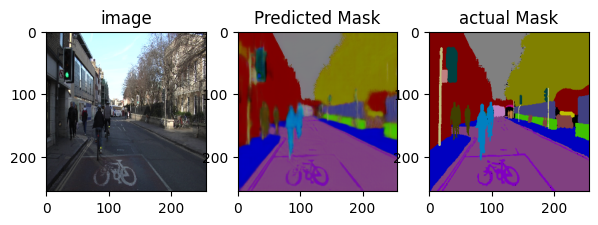

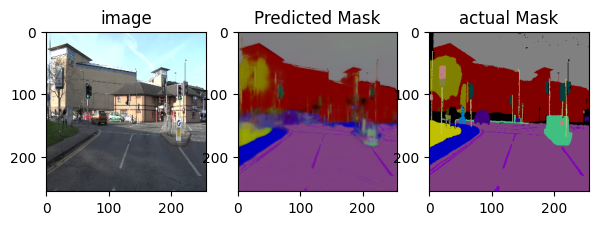

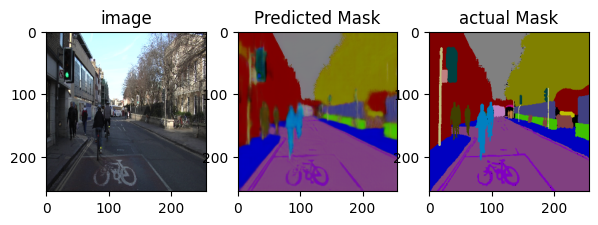

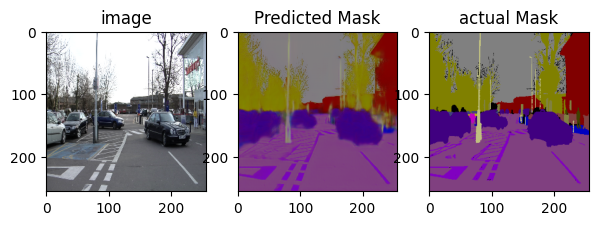

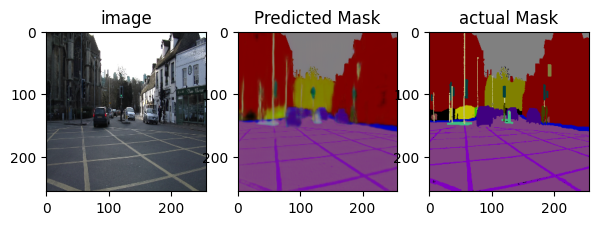

In [287]:
# binary CE - sigmoid - 150 epochs
idx = np.random.randint(0, 16, size = 5)
for i in idx:
    Plotter(actuals[i], sixteenPrediction[i], masks[i])

In [43]:
unet.save('unet_BCE_150epochs.keras')

### Unet - Sigmoid + Binary Focal CE

In [44]:
unet_focal = Unet(input_size=shapes, filters = 16, n_classes = 3, activation='sigmoid')
unet_focal.compile(optimizer='adam',
                   loss='binary_focal_crossentropy',
                   metrics=['accuracy'])
# model.summary()

In [45]:
history_unet_focal = unet_focal.fit(np.array(Train['img']),np.array(Train['mask']),
                                    epochs = 150, verbose = 1,
                                    batch_size = 8,
                                    validation_data = (np.array(Test['img']),np.array(Test['mask'])))

Epoch 1/150


2024-02-02 11:43:59.873396: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inUnet/dropout_45/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


47/47 [==============================] - 20s 141ms/step - loss: 0.1529 - accuracy: 0.2964 - val_loss: 0.8667 - val_accuracy: 0.3309
Epoch 2/150
47/47 [==============================] - 5s 97ms/step - loss: 0.1304 - accuracy: 0.4809 - val_loss: 0.2098 - val_accuracy: 0.3204
Epoch 3/150
47/47 [==============================] - 5s 97ms/step - loss: 0.1264 - accuracy: 0.5121 - val_loss: 0.1434 - val_accuracy: 0.4038
Epoch 4/150
47/47 [==============================] - 5s 98ms/step - loss: 0.1249 - accuracy: 0.5425 - val_loss: 0.1433 - val_accuracy: 0.4310
Epoch 5/150
47/47 [==============================] - 5s 97ms/step - loss: 0.1230 - accuracy: 0.5360 - val_loss: 0.1514 - val_accuracy: 0.3218
Epoch 6/150
47/47 [==============================] - 5s 97ms/step - loss: 0.1220 - accuracy: 0.5431 - val_loss: 0.1498 - val_accuracy: 0.6172
Epoch 7/150
47/47 [==============================] - 5s 97ms/step - loss: 0.1208 - accuracy: 0.5507 - val_loss: 0.1321 - val_accuracy: 0.5484
Epoch 8/150
47/4

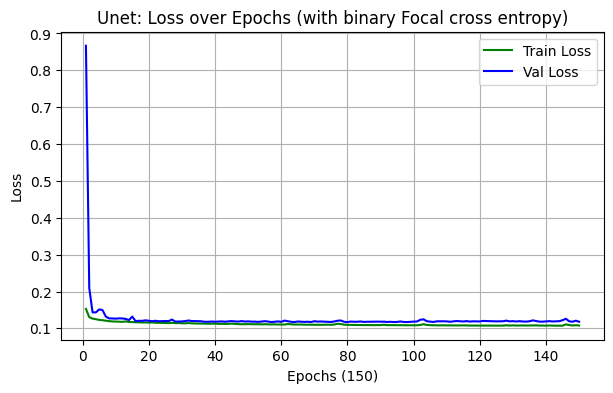

In [46]:
train_loss_history_unet_focal = history_unet_focal.history['loss']
val_loss_history_unet_focal = history_unet_focal.history['val_loss']


epochs = np.arange(1, len(val_loss_history_unet_focal)+1)

plt.figure(figsize=(7, 4))


plt.plot(epochs, train_loss_history_unet_focal, label='Train Loss', color='green')
plt.plot(epochs, val_loss_history_unet_focal, label='Val Loss', color='blue')


plt.title('Unet: Loss over Epochs (with binary Focal cross entropy)')
plt.xlabel('Epochs (150)')
plt.ylabel('Loss')
plt.legend()

plt.grid(True)
plt.show()

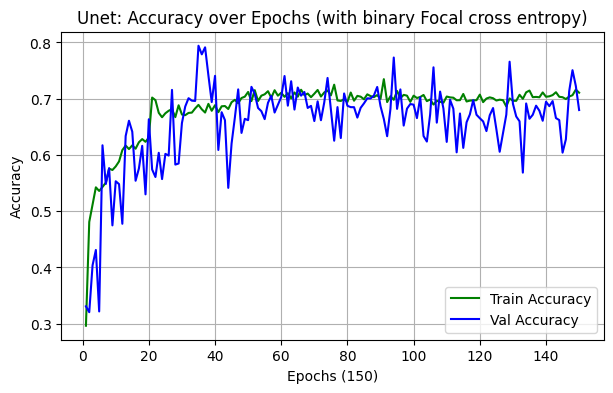

In [47]:
train_acc_history_unet_focal = history_unet_focal.history['accuracy']
val_acc_history_unet_focal = history_unet_focal.history['val_accuracy']


epochs = np.arange(1, len(val_acc_history_unet_focal)+1)

plt.figure(figsize=(7, 4))


plt.plot(epochs, train_acc_history_unet_focal, label='Train Accuracy', color='green')
plt.plot(epochs, val_acc_history_unet_focal, label='Val Accuracy', color='blue')


plt.title('Unet: Accuracy over Epochs (with binary Focal cross entropy)')
plt.xlabel('Epochs (150)')
plt.ylabel('Accuracy')
plt.legend()

plt.grid(True)
plt.show()

In [258]:
unet_focal.evaluate(np.array(Validation['img']), np.array(Validation['mask']))

4/4 [==============================] - 0s 50ms/step - loss: 0.1145 - accuracy: 0.6483


[0.11449728906154633, 0.6482788324356079]

In [50]:
sixteenPrediction2, actuals2, masks2 = predict_batch(Validation, unet_focal)

4/4 [==============================] - 1s 56ms/step


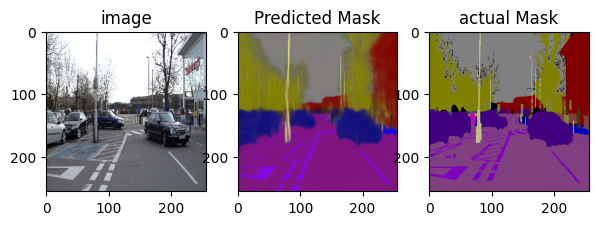

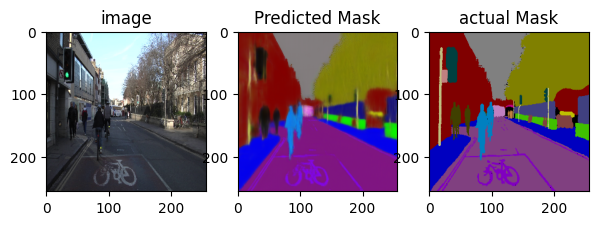

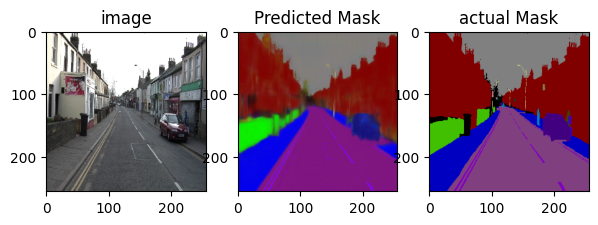

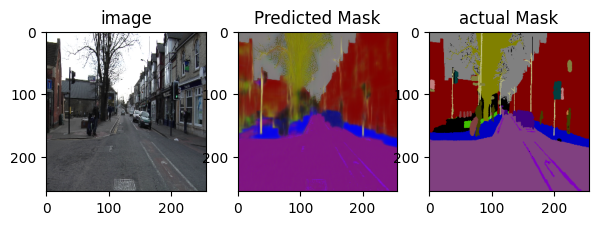

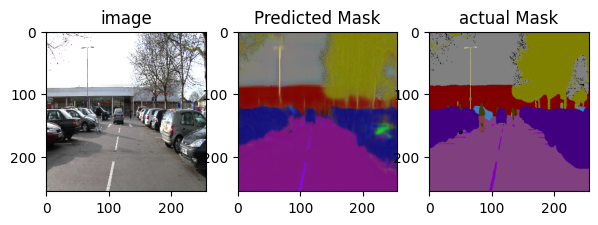

In [290]:
# Binary Focal CE - sigmoid - 150 epochs
idx = np.random.randint(0, 16, size = 5)
for i in idx:
    Plotter(actuals2[i], sixteenPrediction2[i], masks2[i])

In [52]:
unet.save('unet_focal_150epochs.keras')

---

## ResUnet - BCE - sigmoid

In [57]:
resunet = ResUnet(input_size=shapes, filters = 16, n_classes = 3, activation='sigmoid')
resunet.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
# model.summary()

In [58]:
history_resunet = resunet.fit(np.array(Train['img']),np.array(Train['mask']),
                            epochs = 150, verbose = 1,
                            batch_size = 8,
                            validation_data = (np.array(Test['img']),np.array(Test['mask'])))

Epoch 1/150


2024-02-02 12:02:08.146884: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inResUnet/dropout_54/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


47/47 [==============================] - 28s 168ms/step - loss: 0.6434 - accuracy: 0.3583 - val_loss: 0.7720 - val_accuracy: 0.1425
Epoch 2/150
47/47 [==============================] - 6s 124ms/step - loss: 0.5866 - accuracy: 0.5371 - val_loss: 0.6779 - val_accuracy: 0.1517
Epoch 3/150
47/47 [==============================] - 6s 123ms/step - loss: 0.5743 - accuracy: 0.5682 - val_loss: 0.6740 - val_accuracy: 0.2890
Epoch 4/150
47/47 [==============================] - 6s 123ms/step - loss: 0.5665 - accuracy: 0.6074 - val_loss: 0.6664 - val_accuracy: 0.1999
Epoch 5/150
47/47 [==============================] - 6s 124ms/step - loss: 0.5607 - accuracy: 0.6346 - val_loss: 0.6745 - val_accuracy: 0.2000
Epoch 6/150
47/47 [==============================] - 6s 124ms/step - loss: 0.5525 - accuracy: 0.6372 - val_loss: 0.7432 - val_accuracy: 0.1590
Epoch 7/150
47/47 [==============================] - 6s 123ms/step - loss: 0.5491 - accuracy: 0.6386 - val_loss: 0.6911 - val_accuracy: 0.2086
Epoch 8/15

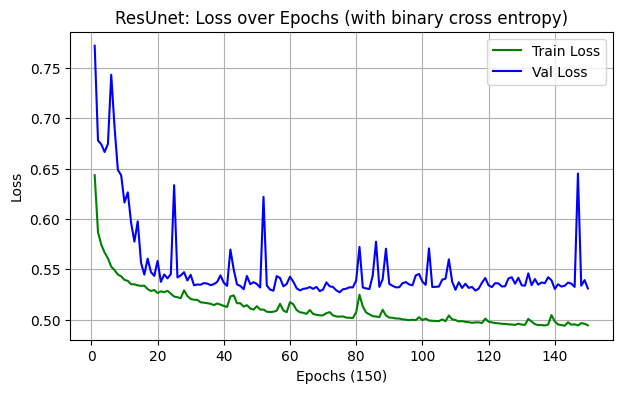

In [59]:
train_loss_history_resunet = history_resunet.history['loss']
val_loss_history_resunet = history_resunet.history['val_loss']


epochs = np.arange(1, len(val_loss_history_resunet)+1)

plt.figure(figsize=(7, 4))


plt.plot(epochs, train_loss_history_resunet, label='Train Loss', color='green')
plt.plot(epochs, val_loss_history_resunet, label='Val Loss', color='blue')


plt.title('ResUnet: Loss over Epochs (with binary cross entropy)')
plt.xlabel('Epochs (150)')
plt.ylabel('Loss')
plt.legend()

plt.grid(True)
plt.show()

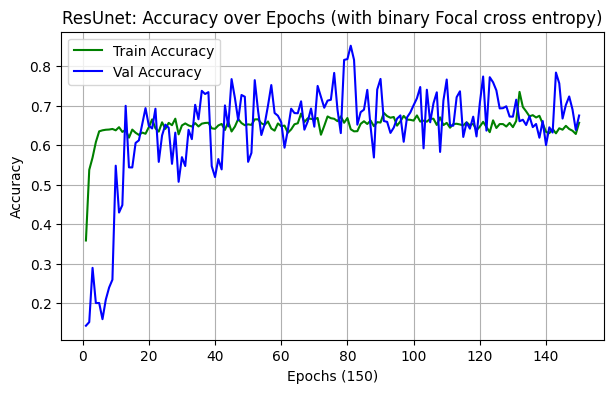

In [60]:
train_acc_history_resunet = history_resunet.history['accuracy']
val_acc_history_resunet = history_resunet.history['val_accuracy']


epochs = np.arange(1, len(val_acc_history_resunet)+1)

plt.figure(figsize=(7, 4))


plt.plot(epochs, train_acc_history_resunet, label='Train Accuracy', color='green')
plt.plot(epochs, val_acc_history_resunet, label='Val Accuracy', color='blue')


plt.title('ResUnet: Accuracy over Epochs (with binary Focal cross entropy)')
plt.xlabel('Epochs (150)')
plt.ylabel('Accuracy')
plt.legend()

plt.grid(True)
plt.show()

In [259]:
resunet.evaluate(np.array(Validation['img']), np.array(Validation['mask']))

4/4 [==============================] - 1s 60ms/step - loss: 0.5231 - accuracy: 0.6868


[0.523131251335144, 0.686845064163208]

In [247]:
predictions3 = resunet.predict(np.array(Validation['img']))

4/4 [==============================] - 0s 66ms/step


In [248]:
iou3 = tf.keras.metrics.MeanIoU(num_classes=3, sparse_y_true=True, sparse_y_pred=True)
iou3.update_state(np.array(Validation['mask']), predictions3)
result3 = iou3.result().numpy()
result3

1.0

In [61]:
sixteenPrediction3, actuals3, masks3 = predict_batch(Validation, resunet)

4/4 [==============================] - 2s 139ms/step


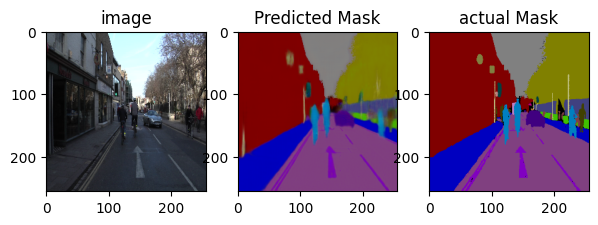

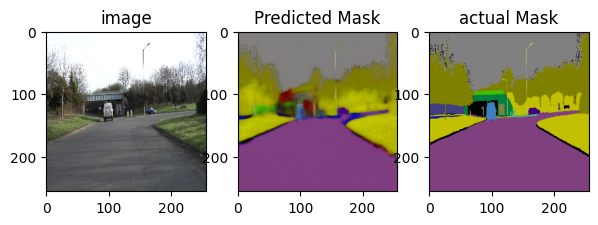

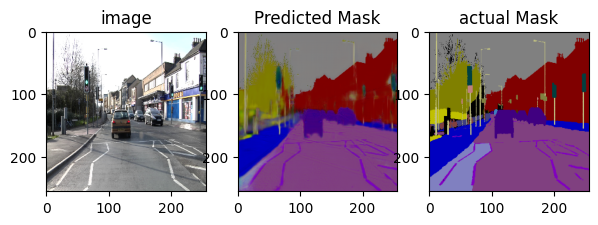

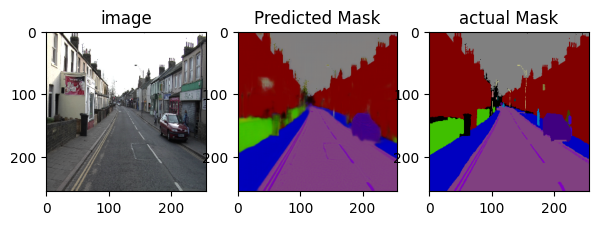

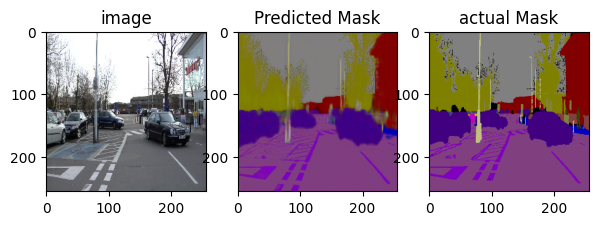

In [292]:
# ResUnet 150 epochs
idx = np.random.randint(0, 16, size = 5)
for i in idx:
    Plotter(actuals3[i], sixteenPrediction3[i], masks3[i])

In [76]:
resunet.save('resunet_BCE_150epochs.keras')

---

## Autoencoder

In [77]:
autoenc = autoencoder((256,256,3))

In [78]:
autoenc.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
# mse since we are trying to minimize the errors between each predicted pixel and the ground truth pixel
autoenc.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_142 (Conv2D)         (None, 256, 256, 16)      448       
                                                                 
 batch_normalization_135 (B  (None, 256, 256, 16)      64        
 atchNormalization)                                              
                                                                 
 activation_126 (Activation  (None, 256, 256, 16)      0         
 )                                                               
                                                                 
 conv2d_143 (Conv2D)         (None, 256, 256, 16)      2320      
                                                                 
 batch_normalization_136 (B  (None, 256, 256, 16)      64    

In [86]:
# trained for 1000 epochs
autoenc.fit(np.array(Train['img']), np.array(Train['img']), epochs = 500, verbose = 1)

Epoch 1/500
12/12 [==============================] - 2s 178ms/step - loss: 0.0048 - accuracy: 0.6323
Epoch 2/500
12/12 [==============================] - 2s 177ms/step - loss: 0.0048 - accuracy: 0.6331
Epoch 3/500
12/12 [==============================] - 2s 179ms/step - loss: 0.0050 - accuracy: 0.6355
Epoch 4/500
12/12 [==============================] - 2s 178ms/step - loss: 0.0050 - accuracy: 0.6280
Epoch 5/500
12/12 [==============================] - 2s 176ms/step - loss: 0.0050 - accuracy: 0.6283
Epoch 6/500
12/12 [==============================] - 2s 178ms/step - loss: 0.0049 - accuracy: 0.6339
Epoch 7/500
12/12 [==============================] - 2s 177ms/step - loss: 0.0047 - accuracy: 0.6318
Epoch 8/500
12/12 [==============================] - 2s 179ms/step - loss: 0.0048 - accuracy: 0.6343
Epoch 9/500
12/12 [==============================] - 2s 178ms/step - loss: 0.0049 - accuracy: 0.6326
Epoch 10/500
12/12 [==============================] - 2s 179ms/step - loss: 0.0049 - accura

In [87]:
pred = autoenc.predict(np.array(Train['img']))

12/12 [==============================] - 1s 53ms/step


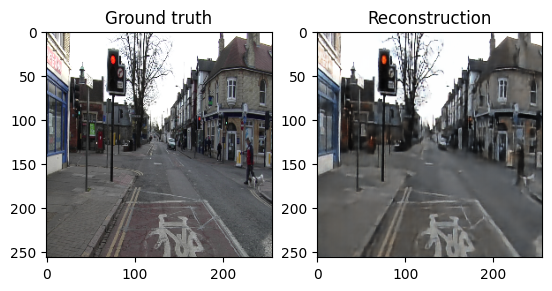

In [260]:
i = 2
plt.subplot(1,2,1)
plt.title('Ground truth')
plt.imshow(np.array(Train['img'][i]))
plt.subplot(1,2,2)
plt.title('Reconstruction')
plt.imshow(pred[i])
plt.show()

In [97]:
autoenc.save('autoencoder_1000epochs.keras')

## Random vs pretrained weights AKA feature maps

In [218]:
# define a new autoencoder model
# my_model = autoencoder((256, 256, 3))
my_model = autoenc

In [280]:
len(my_model.layers)

69

In [219]:
# set intermediate representations for all layers in the model
# except for the first - as it is an input layer
# 64 layers + 5 dropouts of the encoder
outputs = [layer.output for layer in my_model.layers[1:]]
len(outputs) # not 69 since we excluded the input

68

In [220]:
# define a visualization model
# this way we obtain len(my_model.layers) (69) outputs where each output
# correspond to each layer in the outputs list
model_for_visualization = Model(inputs = my_model.input, outputs = outputs)

In [221]:
#Generate random image to be used as input
# img = np.uint8(np.random.uniform(120, 200, (256, 256, 3)))/255
# input_img = np.expand_dims(img, axis=0)

# predict on a single image WITHOUT TRAINING
input_img = np.expand_dims(np.array(Train['img'][1]), axis=0)
feature_maps = model_for_visualization.predict(input_img)
# by doing this we obtain len(my_model.layers) (69) feature maps (69 numpy arrays)

1/1 [==============================] - 1s 588ms/step


### Random (new not trained autoencoder)

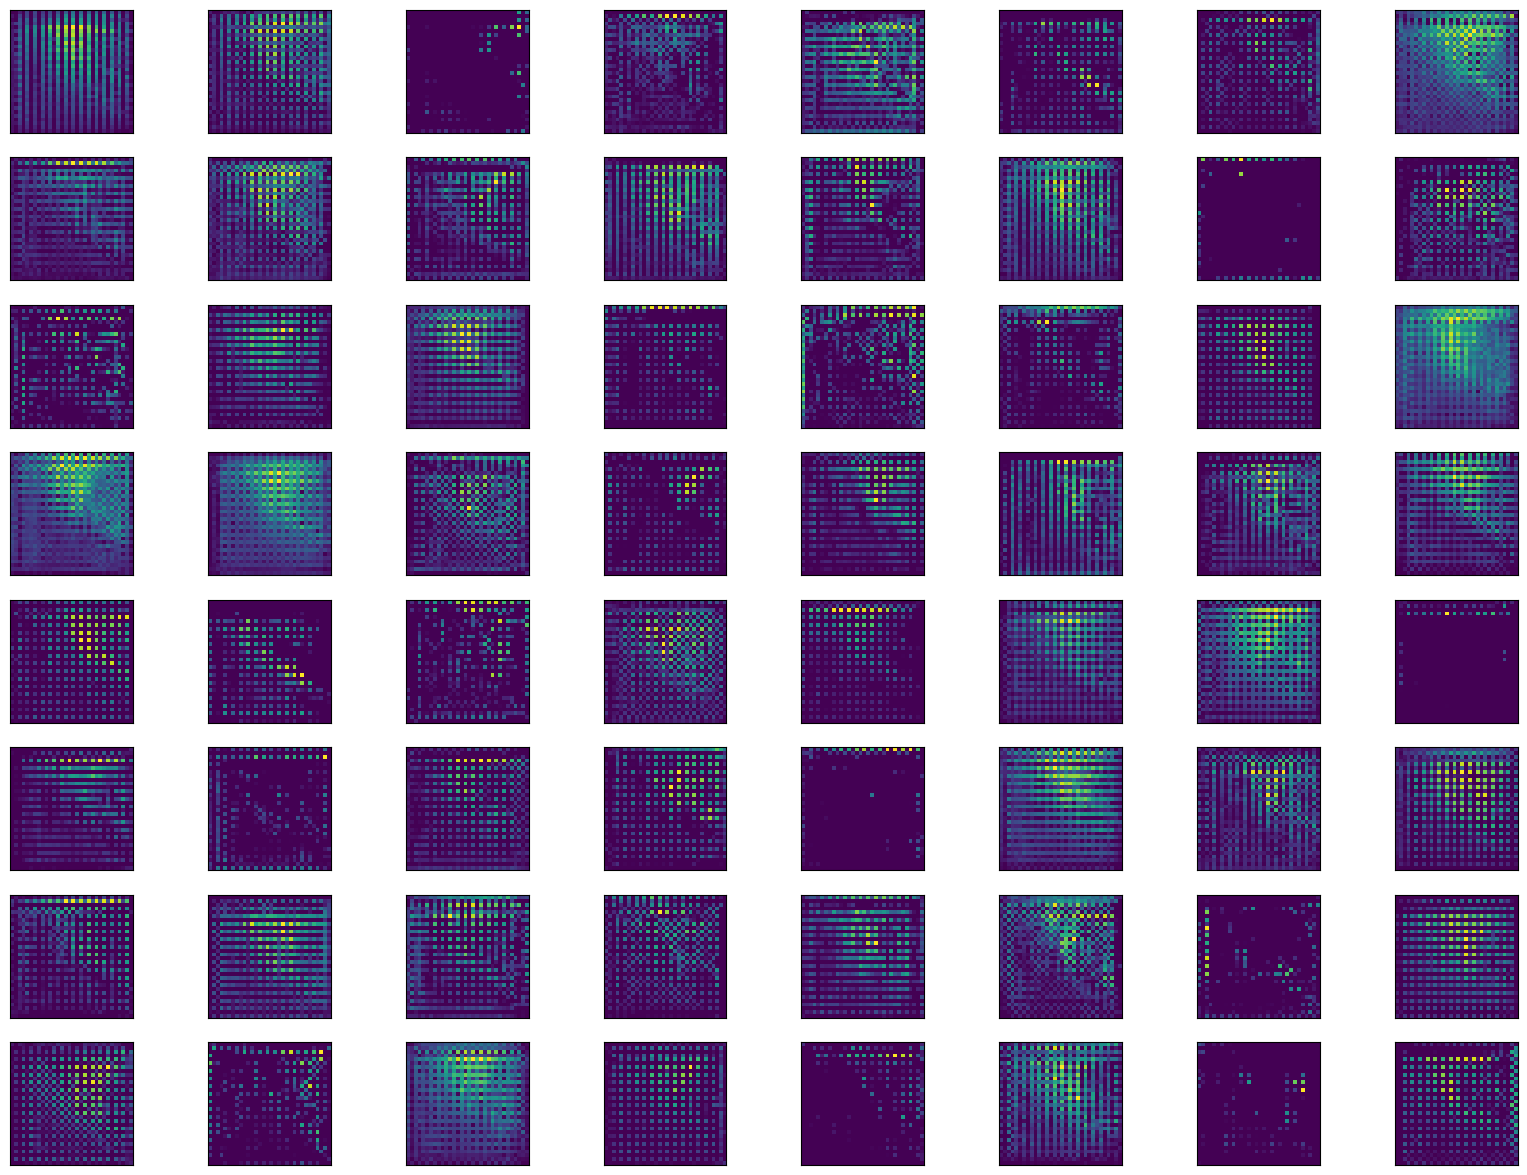

In [217]:
# now plot all 69 feature maps maps in an 8x8 squares
# cut to half autoencoder (take only the encoder part)
layer_num = 45  # Depth of layer = 40
square = 8
ix = 1
plt.figure(figsize=(20, 15))
# for _ in range(square): both for loops
for i in range(1, square + 1):
    for j in range(1, square + 1):
        ax = plt.subplot(square, square, ix)
        # remove axis labels
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(feature_maps[layer_num][0, :, :, ix - 1])
        ix += 1
plt.show()


### Pretrained autoencoder

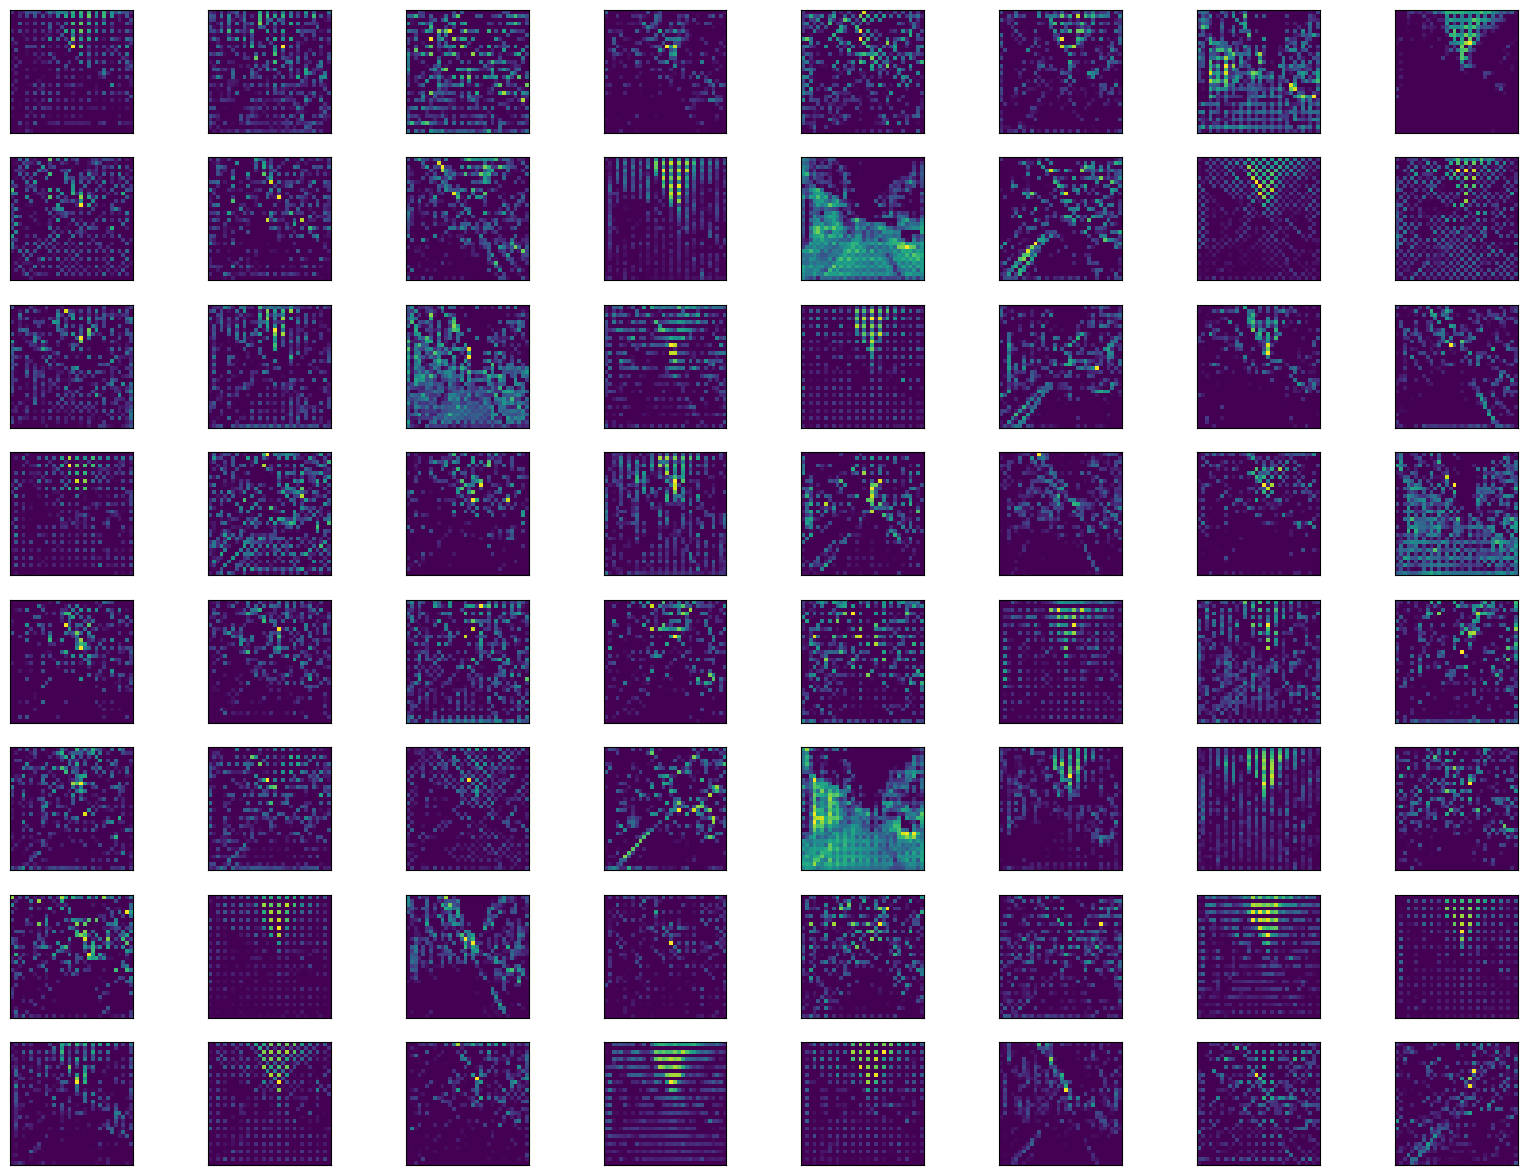

In [222]:
# now plot all 69 feature maps maps in an 8x8 squares
# cut to half autoencoder (take only the encoder part)
layer_num = 45  # Depth of layer = 40
square = 8
ix = 1
plt.figure(figsize=(20, 15))
# for _ in range(square): both for loops
for i in range(1, square + 1):
    for j in range(1, square + 1):
        ax = plt.subplot(square, square, ix)
        # remove axis labels
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        plt.imshow(feature_maps[layer_num][0, :, :, ix - 1])
        ix += 1
plt.show()